In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

In [4]:
df=pd.read_csv('customers.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 919.2+ KB


In [6]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [7]:
df.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [8]:
df=df.drop(columns=["ID"])

In [9]:
df.fillna({"Work_Experience":0, "Family_Size": df["Family_Size"].median()}, inplace=True)

In [10]:
categorical_columns = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"]
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [11]:
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,1,0,22,0,5,1.0,2,4.0,3,D
1,0,1,38,1,2,0.0,0,3.0,3,A
2,0,1,67,1,2,1.0,2,1.0,5,B
3,1,1,67,1,7,0.0,1,2.0,5,B
4,0,1,40,1,3,0.0,1,6.0,5,A


In [12]:
label_encoder = LabelEncoder()
df["Segmentation"] = label_encoder.fit_transform(df["Segmentation"])

In [13]:

X = df.drop(columns=["Segmentation"])
y = df["Segmentation"].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [16]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [17]:
class PeopleClassifier(nn.Module):
    def __init__(self, input_size):
        super(PeopleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        #self.fc3 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)



    def forward(self, x):
      x=F.relu(self.fc1(x))
      x=F.relu(self.fc2(x))
      #x=F.relu(self.fc3(x))
      x=self.fc3(x)
      return x

In [18]:
def train_model(model, train_loader, criterion, optimizer, epochs):
  for epoch in range(epochs):
    model.train()
    for X_batch,y_batch in train_loader:
      optimizer.zero_grad()
      outputs=model(X_batch)
      loss=criterion(outputs,y_batch)
      loss.backward()
      optimizer.step()


    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [19]:
model = PeopleClassifier(input_size=X_train.shape[1])
criterion =nn.CrossEntropyLoss()
optimizer =optim.Adam(model.parameters(), lr=0.001)


In [20]:
train_model(model, train_loader, criterion, optimizer, epochs=100)

Epoch [10/100], Loss: 1.2003
Epoch [20/100], Loss: 1.3466
Epoch [30/100], Loss: 1.1697
Epoch [40/100], Loss: 1.2646
Epoch [50/100], Loss: 1.1029
Epoch [60/100], Loss: 1.1838
Epoch [70/100], Loss: 0.9687
Epoch [80/100], Loss: 1.3606
Epoch [90/100], Loss: 1.0754
Epoch [100/100], Loss: 1.1850


In [21]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())
        actuals.extend(y_batch.numpy())

In [22]:
accuracy = accuracy_score(actuals, predictions)
conf_matrix = confusion_matrix(actuals, predictions)
class_report = classification_report(actuals, predictions, target_names=[str(i) for i in label_encoder.classes_])
print("Name: Prashanth K")
print("Register No: 212223230152")
print(f'Test Accuracy: {accuracy:.2f}%')
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Name: Prashanth K
Register No: 212223230152
Test Accuracy: 0.48%
Confusion Matrix:
 [[239  76 109 160]
 [144 115 147  84]
 [ 76  65 271  60]
 [125  24  42 402]]
Classification Report:
               precision    recall  f1-score   support

           A       0.41      0.41      0.41       584
           B       0.41      0.23      0.30       490
           C       0.48      0.57      0.52       472
           D       0.57      0.68      0.62       593

    accuracy                           0.48      2139
   macro avg       0.47      0.47      0.46      2139
weighted avg       0.47      0.48      0.47      2139



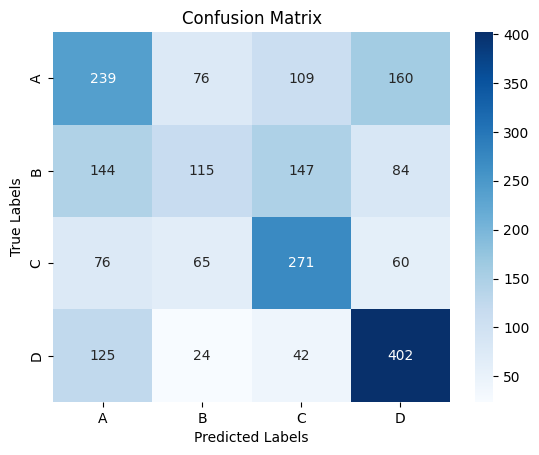

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,fmt='g')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [24]:
# Prediction for a sample input
sample_input = X_test[9].clone().unsqueeze(0).detach().type(torch.float32)
with torch.no_grad():
    output = model(sample_input)
    # Select the prediction for the sample (first element)
    predicted_class_index = torch.argmax(output[0]).item()
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
print("Name: Prashanth K")
print("Register No: 212223230152")
print(f'Predicted class for sample input: {predicted_class_label}')
print(f'Actual class for sample input: {label_encoder.inverse_transform([y_test[12].item()])[0]}')

Name: Prashanth K
Register No: 212223230152
Predicted class for sample input: D
Actual class for sample input: D
